# Numerical Methods for Time Dependent PDEs: Assignment 1

In [1]:
%matplotlib inline
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve, inv
import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = [16, 8]

# Function to solve the ODE u' = f(u) on [t_start, t_start + dt]
def forward_euler(u0, dt, rhs_func):
    return u0 + dt * rhs_func(u0)

# Function to solve the ODE u' = f(u) on [t_start, t_start + dt]
# uses the classical 4 stage Runge-Kutta method
def rk4(u0, dt, rhs_func):
    k1 = rhs_func(u0)
    k2 = rhs_func(u0 + dt * k1 / 2)
    k3 = rhs_func(u0 + dt * k2 / 2)
    k4 = rhs_func(u0 + dt * k3)
    return u0 + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6

## Question 1: *Porous media flow*

Consider the Richards equation, which is a nonlinear diffusion equation, from porous media flow
$$\dfrac{\partial\theta}{\partial t} = \dfrac{\partial}{\partial x}\left( C_0\exp(c\theta)\dfrac{\partial\theta}{\partial x} \right), \quad x \in (0, L), \label{PDE1} \tag{PDE}$$
where $\theta(x,t)$ is the volumetric moisture content. The initial condition is given by
$$\theta(x, 0) = \begin{cases} \theta_1 & \text{ at } x=0 \\ \theta_0 & \text{ for } x > 0\end{cases}. \tag{IC}$$
Furthermore, the boundary conditions are given by
$$u(0,t) = \theta_1 \qquad u(L,t) = 0.1 \quad \text { for all } t > 0 \tag{BC}$$

From the paper, we gather the constants $C_0 = 24 \times 10^{-5} \operatorname{cm}^2\operatorname{min}^{-1}$, $c=13.6$, $\theta_0 = 0.1$ and $\theta_1 = 0.5$.

### Discretization
To discretize \eqref{PDE1}, we are going to use a method of lines approach. First we will discretize the space variable $x$. Following the extra information from the webpage, we have that
\begin{align*}
\left.\dfrac{\partial }{ \partial x} \left[ C(\theta) \dfrac{\partial \theta}{\partial x}\right]  \right\vert_i &\approx \dfrac{C(\theta_{i+\frac{1}{2}}) \left. \dfrac{\partial \theta}{\partial x} \right\vert_{i+\frac{1}{2}} - C(\theta_{i-\frac{1}{2}}) \left. \dfrac{\partial \theta}{\partial x} \right\vert_{i-\frac{1}{2}}}{\Delta x} \\
&\approx \dfrac{\left(\dfrac{C(\theta_{i+1}) + C(\theta_i)}{2}\right)\left( \dfrac{\theta_{i+1} - \theta_i}{\Delta x}\right)  - \left(\dfrac{C(\theta_{i}) + C(\theta_{i-1})}{2}\right) \left( \dfrac{\theta_{i} - \theta_{i-1}}{\Delta x}\right)}{\Delta x} \\
&\approx C_0 \dfrac{\left(\dfrac{\exp(c\theta_{i+1}) + \exp(c \theta_i)}{2}\right)\left( \dfrac{\theta_{i+1} - \theta_i}{\Delta x}\right)  - \left(\dfrac{\exp(c\theta_{i}) + \exp(c \theta_{i-1})}{2}\right) \left( \dfrac{\theta_{i} - \theta_{i-1}}{\Delta x}\right)}{\Delta x} \\
&= C_0\dfrac{\left( \exp(c\theta_{i+1}) + \exp(c \theta_i)\right) \left( \theta_{i+1} - \theta_i \right) -\left( \exp(c\theta_{i}) + \exp(c \theta_{i-1}) \right) \left( \theta_{i} - \theta_{i-1} \right)}{2(\Delta x)^2}
\end{align*}
Hence we get the method of lines ODE system given by
$$\dfrac{\partial \theta_i}{\partial t} = F(\theta_{i-1}, \theta_i, \theta_{i+1}) = C_0\dfrac{\left( \exp(c\theta_{i+1}) + \exp(c \theta_i)\right) \left( \theta_{i+1} - \theta_i \right) -\left( \exp(c\theta_{i}) + \exp(c \theta_{i-1}) \right) \left( \theta_{i} - \theta_{i-1} \right)}{2(\Delta x)^2}$$
We will apply the forward Euler method to numerically solve this system of nonlinear ODEs, that yields at time $n$:
$$\theta^{(n + 1)}_i = \theta^{(n)}_i + \Delta t C_0\dfrac{\left( \exp(c\theta_{i+1}^{(n)}) + \exp(c \theta_i^{(n)})\right) \left( \theta_{i+1}^{(n)} - \theta_i^{(n)} \right) -\left( \exp(c\theta_{i}^{(n)}) + \exp(c \theta_{i-1}^{(n)}) \right) \left( \theta_{i}^{(n)} - \theta_{i-1}^{(n)} \right)}{2(\Delta x)^2}$$

In [2]:
def richards_ode_rhs(theta, dx, C0, c):
    tmp = np.zeros(len(theta))
    for idx in range(1, len(theta) - 1):
        left = (np.exp(c * theta[idx + 1]) + np.exp(c * theta[idx])) * (theta[idx + 1] - theta[idx])
        right = (np.exp(c * theta[idx]) + np.exp(c * theta[idx - 1])) * (theta[idx] - theta[idx - 1])
        tmp[idx] = C0 * (left - right) / (2 * dx ** 2)
    return tmp

def solve_richards_eq(size_space, size_time, length, final_time, output=False):
    # Set initial condition
    theta = 0.1 * np.ones(size_space)
    theta[0] = 0.5
    
    # Constants
    C0 = 4e-6
    c = 13.6
    dx = length / size_space
    dt = final_time / size_time
    
    frame = 1
    frames = np.zeros((final_time, size_space))
    frames[0, :] = theta
    
    rhs_func = lambda u: richards_ode_rhs(u, dx, C0, c)
    for time in range(1, size_time):
        theta[1:-1] = forward_euler(theta, dt, rhs_func)[1:-1]

        # Save a frame every second
        if time % (size_time / final_time) == 0:
            frames[frame, :] = theta
            if output:
                print('Currently at frame ' + str(frame) + ' out of ' + str(final_time) + ' frames.')
            frame += 1
    return frames

Text(0.5, 1.0, 'Porous media flow')

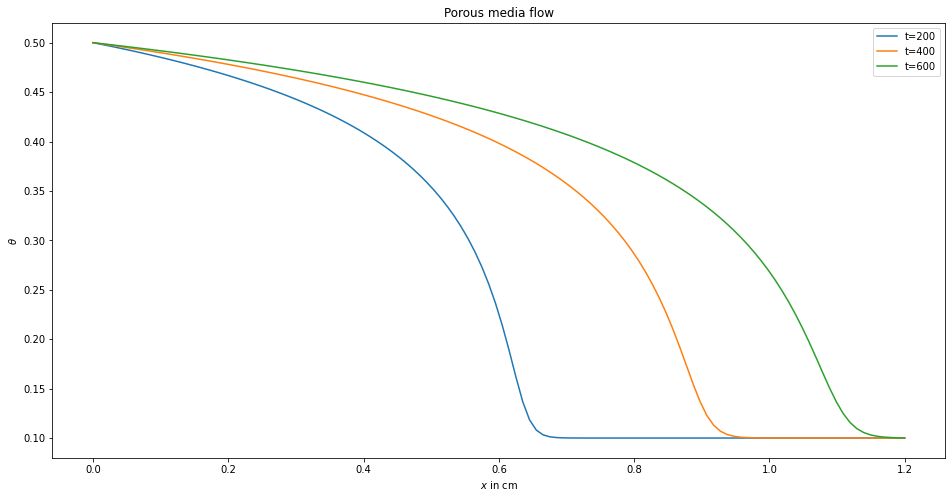

In [3]:
length = 1.2
dx = 0.01
size_space = round(length / dx)
final_time = 700
dt = 0.01
size_time = round(final_time / dt)
x_grid = np.linspace(0, length, size_space)

frames_richards = solve_richards_eq(size_space, size_time, length, final_time)
plt.plot(x_grid, frames_richards[200, :], label="t=200")
plt.plot(x_grid, frames_richards[400, :], label="t=400")
plt.plot(x_grid, frames_richards[600, :], label="t=600")
plt.legend()
plt.xlabel(r"$x$ in cm")
plt.ylabel(r"$\theta$")
plt.title(r"Porous media flow")

# Question 2: *Propagation of domain walls*

In phase-field theory, the propagation of domain walls in liquid crystals maybe modelled by the sixth-order PDE model

\begin{equation}
\dfrac{\partial u}{\partial t} = \delta \dfrac{\partial^6 u}{\partial x^6} - \gamma \dfrac{\partial^4 u}{\partial x^4} + \dfrac{\partial^2 u}{\partial x^2} + u - u^3 = \mathcal{L}u - u^3, \tag{PDE2}
\end{equation}
with
\begin{equation*}
x \in (0, L), \quad \delta > 0, \quad \gamma \in \mathbb{R}, \quad t > 0,
\end{equation*}
and 
$$\mathcal{L} = \delta \dfrac{\partial^6}{\partial x^6} - \gamma \dfrac{\partial^4}{\partial x^4} + \dfrac{\partial^2}{\partial x^2} + I.$$
We are given the following boundary and initial conditions:
\begin{equation}
u(x, 0) = \exp(-x^2 / 16), \quad u(0,t) = 1, \quad u(L, t) = 0
\end{equation}
and $u_x(0, t) = u_x(L, t)=u_{xx}(0,t) = u_{xx}(L, t) = 0$.

## a) Applying a second-order approximation to the spatial derivatives
First we are going to derive the corresponding finite differences matrices, then we will adjust  for the given boundary conditions. To get the second order convergence, I have opted to take a centered difference approach. 

For the second derivative, we hence get the standard tridiagonal matrix $$\mathcal{D}_{2c} = \dfrac{1}{(\Delta x)^2}\operatorname{diag}(1, -2, 1).$$ Then, for the fourth derivative, we use the solution of exercise 2.6 (b), where it was proved that $$\mathcal{D}_{4c} = \mathcal{D}_{2c} \mathcal{D}_{2c} = \dfrac{1}{(\Delta x)^4}\operatorname{diag}(1, -4, 6, -4, 1).$$
Lastly, for the sixth derivative we follow exercise 2.6 (c), where it was proven that $$\mathcal{D}_{6c} = \mathcal{D}_{4c} \mathcal{D}_{2c} = \dfrac{1}{(\Delta x)^6}\operatorname{diag}(1, -6, 15, -20, 15, -6, 1).$$

For the boundary conditions, we implement them following the hint given at the webpage: We simply set $u_0=u_1=u_2 = 1$ and $u_{N} = u_{N-1} = u_{N-2} = 0$.

From this it follows that:
$$\mathcal{L}_{\mathrm{fd}} = \delta \mathcal{D}_{6c} - \gamma\mathcal{D}_{4c} + \mathcal{D}_{2c} + I.$$

Which results in the method of lines system of ODEs:
$$\dot{u} = \mathcal{L}_{fd}u - u^3$$

In [4]:
def D2_fd_spMat(size, dx):
    ones = np.ones(size)
    diag_values = [ones, -2*ones, ones]
    diags = [-1, 0, 1]
    return (dx ** -2) * sparse.spdiags(diag_values, diags, m=size,
                                                n=size, format="csr")
def D4_fd_spMat(size, dx):
    ones = np.ones(size)
    diag_values = [ones, -4*ones, 6*ones, -4*ones, ones]
    diags = [-2, -1, 0, 1, 2]
    return (dx ** -4) * sparse.spdiags(diag_values, diags, m=size,
                                                n=size, format="csr")
def D6_fd_spMat(size, dx):
    ones = np.ones(size)
    diag_values = [ones, -6*ones, 15*ones, -20*ones, 15*ones, -6*ones, ones]
    diags = [-3, -2, -1, 0, 1, 2, 3]
    return (dx ** -6) * sparse.spdiags(diag_values, diags, m=size,
                                                n=size, format="csr")
def space_fd_spMat(size, dx, delta, gamma):
    fd_spMat = (delta * D6_fd_spMat(size, dx) - gamma * D4_fd_spMat(size, dx) 
             + D2_fd_spMat(size, dx) + sparse.eye(size, format="csr"))
    return fd_spMat

## b) Discretizing time using an explicit method
Next, we are going to discretize the time direction using an explicit method, once again the classical forward Euler method.

In [5]:
def rhs_prop_domain_walls(u0, fd_spMat):
    return fd_spMat.dot(u0) - u0 ** 3

def initial_cond(size_space, length):
    return np.exp(-(np.linspace(0, length, size_space) ** 2) / 16)

# Solves the progation model on [0, length] x [0, final_time]
def solve_propagation_model(size_space, size_time, delta, gamma, length, final_time, output=False):
    dx = length / size_space
    dt = final_time / size_time
    
    # Construct the fd matrix
    fd_spMat = space_fd_spMat(size_space, dx, delta, gamma)
    
    u = initial_cond(size_space, length)
    # set bc's explicitly 
    u[0] = u[1] = u[2] = 1
    u[-1] = u[-2] = u[-3] = 0
    
    frame = 1
    frames = np.zeros((final_time, size_space))
    frames[0, :] = u
    rhs_func = lambda u: rhs_prop_domain_walls(u, fd_spMat)
    
    for time in range(1, size_time):
        u[3:-3] = forward_euler(u, dt, rhs_func)[3:-3]

        # Save a frame every second
        if time % (size_time / final_time) == 0:
            frames[frame, :] = u        
            if output:
                print('Currently at frame ' + str(frame) + ' out of ' + str(final_time) + ' frames.')
            frame += 1
    return frames


## c+d) Step sizes and pattern formation

I have chosen for $\Delta t = 0.0001$ and $\Delta x = 0.3$. The results I got are very similar to the ones in the paper, except that the behaviour happens earlier in both the time and space domain. Considering the very different values I took for $\Delta t$ and $\Delta x$, since the ones in the paper don't work, I expect my results to be fully valid.

One observes that in the case $\gamma = -0.6$, we see the existence of precursor ripples, which we don't observe when $\gamma = 0.35$, just as described in the paper.

Text(0.5, 1.0, '$\\gamma=0.35, \\: \\delta=0.12$')

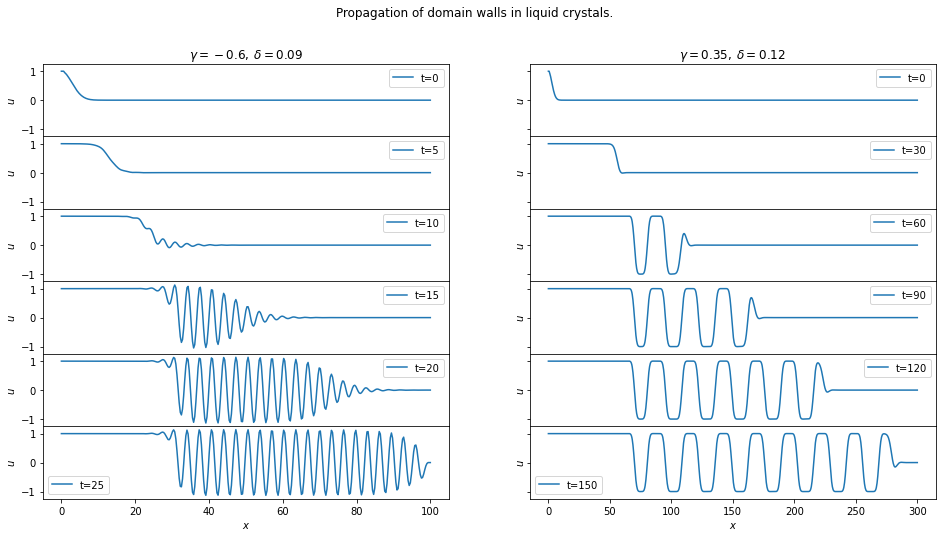

In [6]:
dx = 0.3
length_neg = 100
length_pos = 300
size_space_neg = round(length_neg / dx)
size_space_pos = round(length_pos / dx)
x_grid_neg = np.linspace(0, length_neg, size_space_neg)
x_grid_pos = np.linspace(0, length_pos, size_space_pos)

final_time_neg = 30
final_time_pos = 160
dt = 0.0001
size_time_neg = round(final_time_neg / dt)
size_time_pos = round(final_time_pos / dt)

frames_propagation_neg = solve_propagation_model(size_space_neg, size_time_neg, 
                                                 delta=0.09, gamma=-0.6, length=100, final_time=30)
times_neg = [0, 5, 10, 15, 20, 25]
frames_propagation_pos = solve_propagation_model(size_space_pos, size_time_pos, 
                                                 delta=0.12, gamma=0.35, length=300, final_time=160)
times_pos = [0, 30, 60, 90, 120, 150]

fig = plt.figure()
gs = fig.add_gridspec(ncols=2, nrows=len(times_neg), hspace=0)
axs = gs.subplots(sharex=False, sharey=True)
fig.suptitle('Propagation of domain walls in liquid crystals.')
for idx in range(len(times_neg)):
    axs[idx, 0].plot(x_grid_neg, frames_propagation_neg[times_neg[idx]], label="t=" + str(times_neg[idx]))
    axs[idx, 1].plot(x_grid_pos, frames_propagation_pos[times_pos[idx]], label="t=" + str(times_pos[idx]))
    axs[idx, 0].set_ylabel(r"$u$")
    axs[idx, 1].set_ylabel(r"$u$")
    axs[idx, 0].legend()
    axs[idx, 1].legend()
axs[-1, 0].set_xlabel(r"$x$")
axs[-1, 1].set_xlabel(r"$x$")
axs[0, 0].set_title(r"$\gamma=-0.6, \: \delta=0.09$")
axs[0, 1].set_title(r"$\gamma=0.35, \: \delta=0.12$")

## Question 3: The equal width wave equation

Lastly, we are going to consider the equal width wave equation, which is given by
$$\dfrac{\partial u}{\partial t} + u \dfrac{\partial u}{\partial x} - \mu \dfrac{\partial^3u}{\partial t \partial^2x} = 0, \quad x \in (0, L)$$
An analytical solution is given by
$$u(x,t) = 3c \operatorname{sech}^2(p(x - x_0 - ct))$$
with wave number $p = \sqrt{\dfrac{1}{4\mu}}$ and wave speed $c$.

### a) The analytical solution

This can easily be checked using a CAS system like Mathematica.

### b) Discretizing the space variable using a method of lines approach
As the assignment mentions, we will follow exercise 3.6a closely. For that, we will write the EW equation in conservative form first:
$$\dfrac{\partial u}{\partial t} + \dfrac{1}{2} \dfrac{\partial}{\partial x}u^2 - \mu \dfrac{\partial}{\partial t}\left(\dfrac{\partial^2u}{\partial^2x}\right) = 0$$
Then, we discretize using centered differences, yielding the system of ODEs
$$\dot{u_i} + \dfrac{1}{4\Delta x}(u_{i+1}^2 - u_{i-1}^2) - \dfrac{\mu}{(\Delta x)^2} \left( \dot{u}_{i-1} -2\dot{u}_i + \dot{u}_{i+1}\right) = 0$$
Rearranging and putting the system in matrix form yields
$$M \dot{u} = F(u)$$
with $M = \operatorname{diag}(-\dfrac{\mu}{(\Delta x)^2}, 1 + \dfrac{2\mu}{(\Delta x)^2}, -\dfrac{\mu}{(\Delta x)^2})$ and $F_i(u) = \dfrac{1}{4\Delta x}(u_{i-1}^2 - u_{i+1}^2)$

### c) Reproducing the single soliton
Now we are going to simulate the equal width wave equation using the classical 4 stage Runge-Kutta method. From the article we gather the initial condition 
$$u(x, 0) = 3c \operatorname{sech}^2 [p(x - x_0)],$$
and the following constants: $\mu =1$, $c=1$, $x_0=15$, $\Delta x=0.2$ and $\Delta t=0.2$, we will consider the interval $[0, 80]$.

Text(0.5, 1.0, 'Equal width wave soliton')

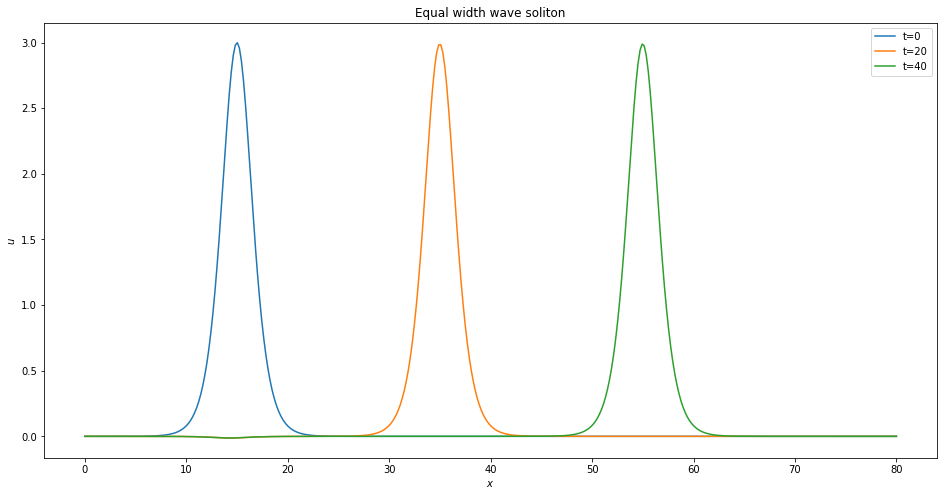

In [7]:
def initial_cond(size, length, mu, c, x0):
    p = np.sqrt(1/ (4 * mu))
    x_vals = np.linspace(0, length, size)
    return 3 * c * (np.cosh(p * (x_vals - x0)) ** -2)

def mass_matrix(size, mu, dx):
    ones = np.ones(size)

    diag_values = [-(mu / dx ** 2) * ones, 1 + 2 * (mu / dx **2) * ones, -(mu / dx ** 2) * ones]
    diags = [-1, 0, 1]
    return sparse.spdiags(diag_values, diags, m=size, n=size, format="csc")

def equal_width_ode_rhs(u0, dx, mass_mat_inv):
    tmp = np.empty_like(u0)
    tmp[:] = u0
    for idx in range(1, len(u0) - 1):
        tmp[idx] = u0[idx - 1] ** 2 - u0[idx + 1] ** 2
    tmp = mass_mat_inv @ tmp
    return tmp / ( 4 * dx)

# Solves the equal width PDE on [0, length] x [0, final_time]
def solve_equal_width_model(size_space, size_time, final_time, length, mu, c, x0, progress=False):
    # set initial condition
    u = initial_cond(size_space, length, mu, c, x0)
    
    dx = length / size_space
    dt = final_time / size_time
    mass_spMat = mass_matrix(size_space, mu, dx)
    # Bad, but is there another way?
    mass_spMat_inv = inv(mass_spMat)
    
    ode_rhs = lambda u: equal_width_ode_rhs(u, dx, mass_spMat_inv)
    
    frame = 1
    frames = np.zeros((final_time, size_space))
    frames[0, :] = u
    
    for time in range(1, size_time):
        u = rk4(u, dt, ode_rhs)
        #u = forward_euler(u, dt, ode_rhs)
        # Save a frame every second
        if time % (size_time / final_time) == 0:
            frames[frame, :] = u
            if progress:
                print('Currently at frame ' + str(frame + 1) + ' out of ' + str(final_time) + ' frames. Time: ' + str(time * dt))
            frame += 1
    return frames

length = 80
dx = 0.2
size_space = round(length / dx)
final_time = 80
dt = 0.2
size_time = round(final_time / dt)
x_grid = np.linspace(0, length, size_space)

mu = 1
c = 1
x0 = 15

frames_ew = solve_equal_width_model(size_space, size_time, final_time, length, mu, c, x0)
plt.plot(x_grid, frames_ew[0, :], label="t=0")
plt.plot(x_grid, frames_ew[20, :], label="t=20")
plt.plot(x_grid, frames_ew[40, :], label="t=40")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$u$")
plt.title(r"Equal width wave soliton")

### d) Error analysis
Now we will look at how the absolute error depends on $\Delta x$ and $\Delta t$. For that we will use numbers also used in the paper. The results are

$$\begin{array}{l|l|l}
\text{Time} & \Delta t = \Delta x = 0.2 & \Delta t = \Delta x = 0.1 \\ \hline
1.0  & 0.1419                      & 0.0859                      \\
5.0  & 0.5845                      & 0.3463                      \\
10.0 & 0.7571                      & 0.4514                      \\
15.0 & 0.7757                      & 0.4927                      \\
20.0 & 0.7705                      & 0.5572                      \\
25.0 & 0.7622                      & 0.6572                     
\end{array}$$

In [8]:
def exact_sol(size, length, mu, c, x0, t):
    p = np.sqrt(1/ (4 * mu))
    x_vals = np.linspace(0, length, size)
    return 3 * c * (np.cosh(p * (x_vals - x0 - c * t)) ** -2)

times = [1, 5, 10, 15, 20, 25]

length = 80
size_space = round(length / dx)
final_time = 30
size_time = round(final_time / dt)

mu = 1
c = 1
x0 = 15

times = [1, 5, 10, 15, 20, 25]
abs_err = np.empty((len(times), 2))
dx = 0.2
dt = 0.2
for idx in range(len(times)):
    size_space = round(length / dx)
    size_time = round(final_time / dt)
    frames = solve_equal_width_model(size_space, size_time, final_time, length, mu, c, x0)
    exact = exact_sol(size_space, length, mu, c, x0, times[idx])
    abs_err[idx, 0] = np.linalg.norm(frames[times[idx]] - exact, 1)
    
dx = 0.1
dt = 0.1
for idx in range(len(times)):
    size_space = round(length / dx)
    size_time = round(final_time / dt)
    frames = solve_equal_width_model(size_space, size_time, final_time, length, mu, c, x0)
    exact = exact_sol(size_space, length, mu, c, x0, times[idx])
    abs_err[idx, 1] = np.linalg.norm(frames[times[idx]] - exact, 1)
print(abs_err)

[[0.14188151 0.08587654]
 [0.58450883 0.3462608 ]
 [0.75707959 0.45142919]
 [0.7757089  0.49271163]
 [0.77052133 0.55724694]
 [0.76216162 0.65721282]]


### f) Checking the conservation quantities

Lastly, we are going to check how well $I_1, I_2$ and $I_3$ are conserved. For the integrals we use the trapezoidal rule to calculate them, for the derivative we will the centered 2nd order approximation. This yields

$$
\begin{array}{l|l|l|l}
\text{Time (s)} & I_1    & I_2    & I_3    \\ \hline
1        & 11.97 & 28.74 & 57.46 \\
5        & 11.97 & 28.74 & 57.46 \\
10       & 11.97 & 28.74 & 57.45 \\
15       & 11.97 & 28.74 & 57.45 \\
20       & 11.97 & 28.74 & 57.45
\end{array}$$
So the quantities are preserved well.

In [9]:
def trapezoidal_rule(func, length, size):
    res = 0
    dx = length / size
    for idx in range(1, size):
        res += (func[idx - 1] + func[idx])
    return (dx / 2) * res

times = [1, 5, 10, 15, 20]

length = 80
dx = 0.2
size_space = round(length / dx)
final_time = 30
dt = 0.2
size_time = round(final_time / dt)

mu = 1
c = 1
x0 = 15

frames = solve_equal_width_model(size_space, size_time, final_time, length, mu, c, x0)

for time in times:
    I1 = trapezoidal_rule(frames[time], length, size_space)
    deriv_sq = (np.diff(frames[time], prepend=0, append=0) / dx ) ** 2
    I2 = trapezoidal_rule(frames[time] ** 2, length, size_space) + trapezoidal_rule(mu * deriv_sq, length, size_space)
    I3 = trapezoidal_rule(frames[time] ** 3, length, size_space)
    print('At time ' + str(time) + 's we have that I1 = ' + str(I1))
    print('At time ' + str(time) + 's we have that I2 = ' + str(I2))
    print('At time ' + str(time) + 's we have that I3 = ' + str(I3))

At time 1s we have that I1 = 11.970000577314346
At time 1s we have that I2 = 28.740630293615286
At time 1s we have that I3 = 57.45587573655264
At time 5s we have that I1 = 11.97000341538513
At time 5s we have that I2 = 28.741406622426155
At time 5s we have that I3 = 57.45538194964152
At time 10s we have that I1 = 11.970004146204705
At time 10s we have that I2 = 28.741342197629685
At time 10s we have that I3 = 57.45477020599904
At time 15s we have that I1 = 11.97000498800948
At time 15s we have that I2 = 28.741141824481986
At time 15s we have that I3 = 57.454158873168666
At time 20s we have that I1 = 11.970006020250395
At time 20s we have that I2 = 28.740938023680798
At time 20s we have that I3 = 57.45354756788609
